<a href="https://colab.research.google.com/github/StrikingHour/Hands-On-Large-Language-Models/blob/main/Chapt_5_Text_Clustering_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")['train']

abstracts = dataset['Abstracts']
titles = dataset['Titles']

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [9]:
embeddings.shape

(44949, 384)

In [10]:
from umap import UMAP

umap_model = UMAP(
    n_components=5, min_dist = 0.0, metric = 'cosine', random_state = 42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [11]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size = 50, metric = "euclidean", cluster_selection_method = "eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

len(set(clusters))

153

Inspecting the Clusters

In [12]:
import numpy as np
import pandas as pd

reduced_embeddings = UMAP(
    n_components = 2, min_dist = 0.0, metric = "cosine", random_state = 42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings, columns = ['x', 'y'])
df['titles'] = titles
df['cluster'] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != '-1', :]
outliers_df = df.loc[df.cluster == '-1', :]

(-7.778345727920533,
 10.878833436965943,
 -1.711702972650528,
 16.388065367937088)

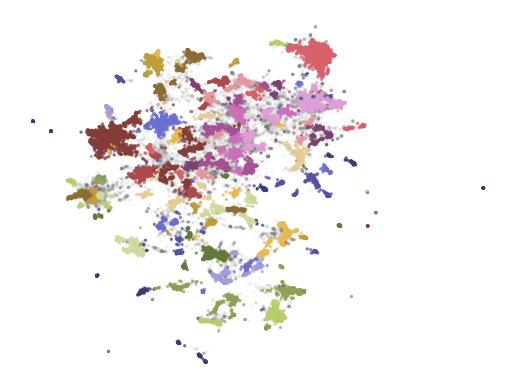

In [13]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y, alpha = 0.05, s = 2, c = 'grey')
plt.scatter(clusters_df.x, clusters_df.y, c = clusters_df.cluster.astype(int), alpha = 0.6, s = 2, cmap = 'tab20b')
plt.axis("off")

From Text Clustering to Topic Modeling

In [14]:
!pip install bertopic

In [16]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    verbose = True
).fit(abstracts, embeddings)

2025-03-07 06:31:34,986 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-07 06:33:46,023 - BERTopic - Dimensionality - Completed ✓
2025-03-07 06:33:46,026 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-07 06:33:49,223 - BERTopic - Cluster - Completed ✓
2025-03-07 06:33:49,251 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-07 06:33:53,288 - BERTopic - Representation - Completed ✓


In [17]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14462                               -1_the_of_and_to   
1        0   2241                 0_question_questions_qa_answer   
2        1   2098                   1_speech_asr_recognition_end   
3        2    903               2_image_visual_multimodal_images   
4        3    887  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     54           147_counseling_mental_therapy_health   
149    148     53                     148_chatgpt_its_openai_has   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51         151_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [question, questions, qa, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [image, visual, multimodal, images, vision, mo...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [counseling, mental, therapy, health, psychoth...   
149  [chatgpt, its, openai, has, it, tasks, capabil...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Cross-lingual text classification aims at t...  
1    [  Question generation (QG) attempts to solve ...  
2    [  End-to-end models have achieved impressive ...  
3    [  In this paper we propose a model to learn m...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  Mental health care poses an increasingly se...  
149  [  Over the last few years, large language mod...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  While there has been significant progress t...  

[153 rows x 5 columns]

In [18]:
topic_model.find_topics("topic modeling")

([22, -1, 50, 38, 84],
 [0.95448655, 0.91218555, 0.9067658, 0.9051957, 0.9026561])

In [19]:
topic_model.get_topic(22)

[('topic', 0.06782148231481569),
 ('topics', 0.03509097163093816),
 ('lda', 0.0162350543969945),
 ('latent', 0.013482620892138605),
 ('document', 0.01258276852968132),
 ('documents', 0.012463820004375148),
 ('modeling', 0.011571581804609226),
 ('dirichlet', 0.009901318233964887),
 ('word', 0.00852094200971816),
 ('allocation', 0.007792539607690728)]

In [20]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]


22

In [21]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings = reduced_embeddings,
    width = 1200,
    hide_annotations = True
)

fig.update_layout(font = dict(size = 16))

In [22]:
topic_model.visualize_barchart()

In [23]:
topic_model.visualize_heatmap(n_clusters = 30)

In [24]:
topic_model.visualize_hierarchy()

In [25]:
from copy import deepcopy

original_topics = deepcopy(topic_model.topic_representations_)



In [27]:
def topic_differences(model, original_topics, nr_topics = 5):
  df = pd.DataFrame(columns = ['Topic', 'Original', 'Updated'])
  for topic in range(nr_topics):
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

In [28]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model = representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  answering | questions | answer | question | co...  
1  phonetic | encoder | language | speech | trans...  
2  captioning | multimodal | visual | visually | ...  
3  summarization | summarizers | summaries | summ...  
4  translation | translate | translated | transla...

In [29]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity = 0.2)
topic_model.update_topics(abstracts, representation_model = representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  questions | answering | retrieval | comprehens...  
1           speech | asr | audio | model | automatic  
2       visual | multimodal | modal | captions | vqa  
3  summarization | summaries | abstractive | eval...  
4  translation | nmt | neural | parallel | multil...

In [30]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 153/153 [00:15<00:00,  9.95it/s]


Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                  Updated  
0  Question answering systems |  |  |  |   
1          Speech recognition |  |  |  |   
2     Image-language learning |  |  |  |   
3               Summarization |  |  |  |   
4                Science/Tech |  |  |  |

In [33]:
!pip install datamapplot


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5967 sha256=490d29fdc1291cd80eecc8d8190e6134e391650b81c721e0edff1fccb2a9bb25
  Stored in directory: /root/.cache/pip/wheels/4c/87/93/c44242a244e4cea2cb9f5414ec450ababd7acac8b3377c3f9e
Successfully built Pyqtree


In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

In [34]:
import datamapplot

fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)

NameError: name 'datamapplot' is not defined